In [1]:
#
#!pip install whatstk

In [37]:
import pandas as pd
import re

# Load the entire file
with open("/Users/leonardrosen/Documents/Projects/nico/data/chat_muji_lenny.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Clean up unicode RTL marks (optional but helpful)
text = text.replace('\u200e', '')

# Pattern that matches entire messages
pattern = re.compile(
    r'\[(\d{2}\.\d{2}\.\d{2}), (\d{2}:\d{2}:\d{2})\] (.*?): (.*?)(?=\n\[\d{2}\.\d{2}\.\d{2}, \d{2}:\d{2}:\d{2}\]|\Z)', 
    re.DOTALL
)

# Extract matches
records = []
for match in pattern.finditer(text):
    date_str, time_str, sender, message = match.groups()
    timestamp = f"{date_str} {time_str}"
    records.append((timestamp, sender.strip(), message.strip()))

# Build DataFrame
df = pd.DataFrame(records, columns=["date", "username", "message"])
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%y %H:%M:%S")

print(df.head())

                 date       username                              message
0 2023-12-11 10:06:14  MuGPT Premium                          How's my bb
1 2023-12-11 10:06:17  MuGPT Premium            I just got back to Berlin
2 2023-12-11 10:21:46          Lenny                        image omitted
3 2023-12-11 10:22:09  MuGPT Premium                                Cutee
4 2023-12-11 10:22:16  MuGPT Premium  Jealous that the weather is so good


In [97]:
## who is the bigger simp?

def count_sentence(user, string):
    """
    Count the number of times a specific string appears in messages from a specific user.
    """
    return df.query("username == @user and message.str.contains(@string, na=False)", engine="python").shape[0]

def analyse_string(person1, person2, string_in_question, meaning):
    """
    Analyse the number of times a specific string appears in messages from two users.
    """
    count1 = count_sentence(person1, string_in_question)
    count2 = count_sentence(person2, string_in_question)

    if count1 >= count2:
        max_simp, max_count = person1, count1
        min_simp, min_count = person2, count2
    else:
        max_simp, max_count = person2, count2
        min_simp, min_count = person1, count1

    print(f"{max_simp} {meaning}!\n{max_simp} writes: '{string_in_question}' {max_count} times\nwhile {min_simp} only wrote it {min_count}. thats only {min_count/(min_count+max_count)*100:.2f}% of all mentions.")

checks = [("love", "is the bigger simp"), 
          ("miss you", "has the most anxious attachment style"), 
          ("stinky", "seems like a bigger stinky"),
          ("pretty", "has the most pretty baby"),
          ("beautiful", "has the most beautiful baby"),
          ("baby", "'babies' the most"),
          ("image omitted", "sends more images"),
          ("horny", "is the hornier"),
          ("hot", "has the hottest bb"),]

me = 'Lenny'
Muji = 'MuGPT Premium'
for string, meaning in checks:
    analyse_string(Muji, me, string, meaning)

MuGPT Premium is the bigger simp!
MuGPT Premium writes: 'love' 218 times
while Lenny only wrote it 147. thats only 40.27% of all mentions.
MuGPT Premium has the most anxious attachment style!
MuGPT Premium writes: 'miss you' 197 times
while Lenny only wrote it 77. thats only 28.10% of all mentions.
Lenny seems like a bigger stinky!
Lenny writes: 'stinky' 81 times
while MuGPT Premium only wrote it 29. thats only 26.36% of all mentions.
MuGPT Premium has the most pretty baby!
MuGPT Premium writes: 'pretty' 55 times
while Lenny only wrote it 18. thats only 24.66% of all mentions.
Lenny has the most beautiful baby!
Lenny writes: 'beautiful' 6 times
while MuGPT Premium only wrote it 3. thats only 33.33% of all mentions.
MuGPT Premium 'babies' the most!
MuGPT Premium writes: 'baby' 466 times
while Lenny only wrote it 79. thats only 14.50% of all mentions.
MuGPT Premium sends more images!
MuGPT Premium writes: 'image omitted' 1289 times
while Lenny only wrote it 982. thats only 43.24% of all 

In [67]:
count_sentence(Muji, string_in_question)

124

In [ ]:
from IPython.display import display, HTML

# Set max rows to display
pd.set_option('display.max_rows', 200)

# Render DataFrame inside scrollable <div>
display(HTML(df.query("message.str.contains('missed', na=False)", engine="python").head(200).to_html(max_rows=200, notebook=True, escape=False, 
    classes='table table-striped table-hover', 
    border=0, 
)))

# Optional: add scroll styling manually if needed
# display(HTML('<div style="height: 400px; overflow: auto;">' + df.head(200).to_html() + '</div>'))

SyntaxError: unmatched ')' (172103156.py, line 10)

In [55]:
df.head(2)
df['date'] = pd.to_datetime(df['date'])

In [40]:
total_messages = len(df)
days_active = (df['date'].max() - df['date'].min()).days + 1
avg_per_day = total_messages / days_active

print(f"Total messages: {total_messages}")
print(f"Days active: {days_active}")
print(f"Average messages per day: {avg_per_day:.2f}")

Total messages: 27880
Days active: 586
Average messages per day: 47.58


In [41]:
messages_per_user = df['username'].value_counts()
print("Messages per user:")
print(messages_per_user)

Messages per user:
username
MuGPT Premium    16669
Lenny            11211
Name: count, dtype: int64


In [42]:
call_keywords = ["call", "video", "missed"]
call_msgs = df[df['message'].str.lower().str.contains('|'.join(call_keywords))]

In [43]:
call_attempts = call_msgs['username'].value_counts()
print("Call attempts by user:")
print(call_attempts)

Call attempts by user:
username
MuGPT Premium    900
Lenny            285
Name: count, dtype: int64


In [44]:
import re
from src.utils import classify_call, extract_call_duration, classify_direction, clean_message

In [45]:
call_msgs = call_msgs.copy()

call_msgs.loc[:, 'call_type'] = call_msgs['message'].apply(classify_call)

call_stats = call_msgs.groupby(['username', 'call_type']).size().unstack(fill_value=0)

print("Call stats (user vs. call type):")
print(call_stats)

Call stats (user vs. call type):
call_type      missed  other
username                    
Lenny              10    275
MuGPT Premium     433    467


In [46]:

voice_calls = df[df['message'].str.startswith("Voice call")].copy()
voice_calls['duration_min'] = voice_calls['message'].apply(extract_call_duration)

total_minutes = voice_calls['duration_min'].sum()
total_hours = total_minutes / 60

print(f"Total voice call time: {total_minutes} minutes ({total_hours:.2f} hours)")

Total voice call time: 36 minutes (0.60 hours)


In [20]:
fig = fb.user_interventions_count_linechart()
plot(fig)

'temp-plot.html'

In [21]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
plot(fig)

'temp-plot.html'

In [22]:
fig = fb.user_interventions_count_linechart(cumulative=True, title='User inteventions count (cumulative)')
plot(fig)

'temp-plot.html'

In [14]:
fig = fb.user_interventions_count_linechart(msg_length=True, cumulative=True, title='Characters sent by user (cumulative)')
plot(fig)

'temp-plot.html'

In [23]:
fig = fb.user_interventions_count_linechart(date_mode='weekday', title='User interventions count (weekly)', xlabel='Week day')
plot(fig)

'temp-plot.html'

In [29]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# 1. Filter only "Voice call" messages
voice_calls = df[df['message'].str.lower().str.startswith("voice call")].copy()


voice_calls['duration_min'] = voice_calls['message'].apply(extract_call_duration)

# 3. Aggregate by username
call_stats = voice_calls.groupby('username')['duration_min'].agg(['sum', 'count']).rename(
    columns={'sum': 'total_minutes', 'count': 'call_count'}
)

# 4. Add hours for convenience
call_stats['total_hours'] = call_stats['total_minutes'] / 60

print("Voice Call Stats per Person:")
print(call_stats)

# 5. Plot: Total call minutes per person
call_stats['total_minutes'].plot(kind='barh', figsize=(8, 4))
plt.xlabel("Total Minutes on Voice Calls")
plt.title("Voice Call Duration by Person initiating")
plt.tight_layout()
plt.show()

Voice Call Stats per Person:
Empty DataFrame
Columns: [total_minutes, call_count, total_hours]
Index: []


TypeError: no numeric data to plot

In [31]:
voice_calls = df[df['message'].str.lower().str.startswith("voice call")].copy()
voice_calls

,date,username,message,clean_msg


In [ ]:
df.query("username == 'Lenny' and message.str.contains('image omitted', na=False)", engine="python")

,date,username,message,clean_msg
17,2023-12-11 15:51:02,Lenny,"We’re home soon okay\n‎[11.12.23, 16:21:39] Le...","we’re home soon okay\n[11.12.23, 16:21:39] len..."
54,2023-12-13 10:37:27,Lenny,"Cutie\n‎[13.12.23, 13:51:05] MuGPT Premium: ‎i...","cutie\n[13.12.23, 13:51:05] mugpt premium: ima..."
55,2023-12-13 15:00:17,Lenny,I would know something that would just fit in ...,i would know something that would just fit in ...
57,2023-12-13 15:45:09,Lenny,"Is she even trying tho\n‎[13.12.23, 19:20:08] ...","is she even trying tho\n[13.12.23, 19:20:08] m..."
61,2023-12-13 19:42:35,Lenny,Why are you sending this to meeee😭😭😭😭😂😂😂\n‎[13...,why are you sending this to meeee😭😭😭😭😂😂😂\n[13....
...,...,...,...,...
24676,2025-07-08 15:07:08,Lenny,"Waiting downstairs\n‎[08.07.25, 16:00:04] Lenn...","waiting downstairs\n[08.07.25, 16:00:04] lenny..."
24733,2025-07-10 13:27:19,Lenny,"🙂‍↔️\n‎[10.07.25, 14:08:51] MuGPT Premium: ‎im...","🙂‍↔️\n[10.07.25, 14:08:51] mugpt premium: imag..."
24771,2025-07-11 21:50:57,Lenny,"Get a life\n‎[11.07.25, 21:51:11] MuGPT Premiu...","get a life\n[11.07.25, 21:51:11] mugpt premium..."
25065,2025-07-17 16:57:56,Lenny,"baby\n‎[17.07.25, 16:57:57] Lenny: ‎image omitted","baby\n[17.07.25, 16:57:57] lenny: image omitted"


In [ ]:
d

,date,username,message,clean_msg
0,2023-12-11 10:06:14,MuGPT Premium,How's my bb,how's my bb
1,2023-12-11 10:06:17,MuGPT Premium,"I just got back to Berlin\n‎[11.12.23, 10:21:4...","i just got back to berlin\n[11.12.23, 10:21:46..."
2,2023-12-11 10:22:09,MuGPT Premium,Cutee,cutee
3,2023-12-11 10:22:16,MuGPT Premium,Jealous that the weather is so good,jealous that the weather is so good
4,2023-12-11 11:22:54,MuGPT Premium,Can you send me Dani's number?,can you send me dani's number?
...,...,...,...,...
25136,2025-07-18 12:06:13,Lenny,lets talk again after lunch depends on where I...,lets talk again after lunch depends on where i...
25137,2025-07-18 12:06:21,Lenny,when are we going to shin and ferdi,when are we going to shin and ferdi
25138,2025-07-18 12:06:26,MuGPT Premium,7?,7?
25139,2025-07-18 12:06:30,MuGPT Premium,it starts at 6,it starts at 6


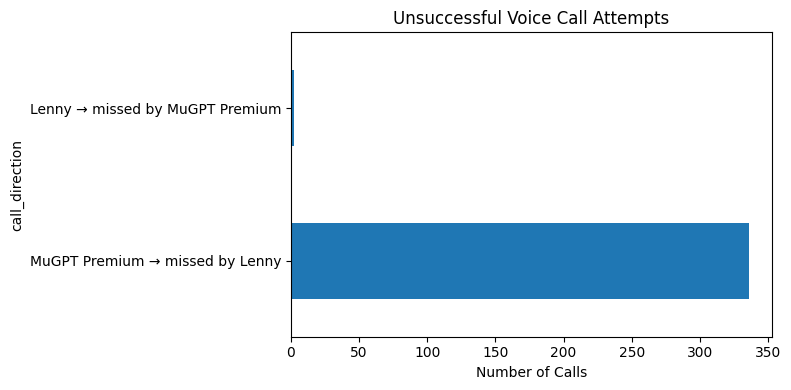

Unsuccessful call attempts:

call_direction
MuGPT Premium → missed by Lenny    336
Lenny → missed by MuGPT Premium      2
Name: count, dtype: int64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df['date'] = pd.to_datetime(df['date'])
df['clean_msg'] = df['message'].apply(clean_message)

missed_calls_df = df[df['clean_msg'].str.contains("voice call. no answer|missed voice call")].copy()

your_name = "Lenny"
friend_name = "MuGPT Premium"


missed_calls_df['call_direction'] = missed_calls_df.apply(
    lambda row: classify_direction(row, your_name, friend_name), axis=1
)

counts = missed_calls_df['call_direction'].value_counts()

counts = counts[counts.index != "unknown"]

counts.plot(kind='barh', figsize=(8, 4))
plt.title("Unsuccessful Voice Call Attempts")
plt.xlabel("Number of Calls")
plt.tight_layout()
plt.show()

# Print breakdown
print("Unsuccessful call attempts:\n")
print(counts)

In [27]:
df.head()

,date,username,message,clean_msg
0,2023-12-11 10:06:14,MuGPT Premium,How's my bb,how's my bb
1,2023-12-11 10:06:17,MuGPT Premium,"I just got back to Berlin\n‎[11.12.23, 10:21:4...","i just got back to berlin\n[11.12.23, 10:21:46..."
2,2023-12-11 10:22:09,MuGPT Premium,Cutee,cutee
3,2023-12-11 10:22:16,MuGPT Premium,Jealous that the weather is so good,jealous that the weather is so good
4,2023-12-11 11:22:54,MuGPT Premium,Can you send me Dani's number?,can you send me dani's number?
